In this notebook we examine the dependency of velocity and persistence on cell density.
The exepriment used is of FACSed DE cell on a plate.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.stats as stats
from matplotlib.collections import LineCollection
import pandas as pd
# get_colormap
from matplotlib import cm
import os
from skimage.io import imread
from scipy.stats import linregress
from migration_metrics_functions import *

In [3]:
# Load original data
DATA_PATH = r'D:\David\THESIS\tracks_dataframes\tracks_df_2025_01_22_2DFACS_FOXA2positive_lateday2.csv'
trajectory_df = pd.read_csv(DATA_PATH)
trajectory_df.head()

,file,ID,track_id,t,normalized_time,step,x_pixels,y_pixels,x_microns,y_microns,major_axis_length_microns,minor_axis_length_microns
0,tracks_01.h5,132,tracks_01.h5_132,0,0,0,2008.065430,126.762512,642.580938,40.564004,23.017954,13.008879
1,tracks_01.h5,132,tracks_01.h5_132,5,5,1,2008.393555,128.677856,642.685938,41.176914,23.756619,12.801699
2,tracks_01.h5,132,tracks_01.h5_132,10,10,2,2006.356445,128.275421,642.034063,41.048135,27.521301,15.038785
3,tracks_01.h5,132,tracks_01.h5_132,15,15,3,2003.178955,122.404404,641.017266,39.169409,23.435100,13.688422
4,tracks_01.h5,132,tracks_01.h5_132,20,20,4,2003.536621,121.145500,641.131719,38.766560,23.653306,14.377905


In [4]:
# Preprocess data
trajectory_df['movie'] = trajectory_df['track_id'].apply(lambda x: x.split('_')[1].split('.')[0])
trajectory_df['frame'] = trajectory_df['t'] / 5  # assuming 5 minutes interval
trajectory_df['dx_microns'] = trajectory_df.groupby('track_id')['x_microns'].diff().fillna(0)
trajectory_df['dy_microns'] = trajectory_df.groupby('track_id')['y_microns'].diff().fillna(0)
trajectory_df['v_x'] = trajectory_df['dx_microns'] / 5  # velocity in microns per minute
trajectory_df['v_y'] = trajectory_df['dy_microns'] / 5  # velocity in microns per minute
trajectory_df['velocity'] = np.sqrt(trajectory_df['dx_microns']**2 + trajectory_df['dy_microns']**2) / 5  # velocity in microns per minute
# set velocity at step 0 to NaN to avoid bias
trajectory_df.loc[trajectory_df['step'] == 0, 'v_x'] = np.nan
trajectory_df.loc[trajectory_df['step'] == 0, 'v_y'] = np.nan
trajectory_df.loc[trajectory_df['step'] == 0, 'velocity'] = np.nan

# filter by track length (at least 10 steps)
trajectory_df = trajectory_df.groupby('track_id').filter(lambda x: len(x) >= 10)

In [5]:
MAX_INTENISITY_PROJECTIONS = r'D:\David\endoderm_migration\raw_data\2025_01_22_2DFACS_FOXA2positive_lateday2\max_intensity_projections_red_channel'

# get the max intensity projections
max_intensity_projections = [f for f in os.listdir(MAX_INTENISITY_PROJECTIONS) if f.endswith('.tif')]
max_intensity_projections.sort()

# get the binary mask stack
BINARY_MASK_STACK_PATH = r'D:\David\endoderm_migration\raw_data\2025_01_22_2DFACS_FOXA2positive_lateday2\cellpose_segmentation'
binary_mask_stack_paths = [f for f in os.listdir(BINARY_MASK_STACK_PATH) if f.endswith('.tif')]
binary_mask_stack_paths.sort()

In [6]:
def get_avg_fluorescence_intensity_per_frame(max_intensity_projection):
    avg_fluorescence_intensities = []

    img_path = os.path.join(MAX_INTENISITY_PROJECTIONS, max_intensity_projection)
    img = imread(img_path).astype(float)  # ensure float for subtraction

    for frame_idx in range(img.shape[0]):
        # extract the actual image for this frame
        frame_img = img[frame_idx]

        # compute mean intensity
        avg_intensity = frame_img.mean()
        avg_fluorescence_intensities.append(avg_intensity)

    # pack into DataFrame
    avg_intensity_df = pd.DataFrame({
        'avg_intensity': avg_fluorescence_intensities,
        'frame': np.arange(len(avg_fluorescence_intensities)),
        'max_intensity_projection': max_intensity_projection
    })
    avg_intensity_df['movie'] = max_intensity_projection.split('xy')[1].split('_')[0]
    return avg_intensity_df

# get average velocites for each frame by grouping by movie and frame
def get_avg_velocity_per_frame(trajectory_df):
    # drop NaN values in velocity (step 0)
    trajectory_df = trajectory_df.dropna(subset=['velocity'])
    avg_velocity_df = trajectory_df.groupby(['movie', 'frame'])['velocity'].mean().reset_index()
    return avg_velocity_df

def get_cell_density_per_frame(binary_mask_stack_path):
    """
    Given a multi‑page TIFF of binary masks (0 background, 1 cell),
    returns a DataFrame with columns:
      - frame: frame index
      - cell_pixel_fraction: fraction of pixels that are ‘1’
    """
    # load the stack as (n_frames, height, width)
    masks = imread(os.path.join(BINARY_MASK_STACK_PATH, binary_mask_stack_path))
    densities = []
    for i in range(masks.shape[0]):
        frame = masks[i].astype(bool)
        # fraction of pixels belonging to cells
        frac = frame.mean()
        densities.append(frac)
        print(f"Frame {i}: cell density = {frac:.3f}")

    densities_df = pd.DataFrame({
        'frame': np.arange(len(densities)),
        'cell_density': densities
    })
    # pull out movie name the same way you did before:
    fname = os.path.basename(binary_mask_stack_path)
    movie = fname.split('xy')[1].split('_')[0]
    densities_df['movie'] = movie
    return densities_df

In [7]:
# # calculate the average fluorescence intensity for each frame
avg_fluorescence_intensity_df = pd.DataFrame()
for max_intensity_projection in max_intensity_projections:
    avg_fluorescence_intensity_df = pd.concat([avg_fluorescence_intensity_df, get_avg_fluorescence_intensity_per_frame(max_intensity_projection)])
avg_fluorescence_intensity_df.reset_index(drop=True, inplace=True)

# calculate the average velocity for each frame
avg_velocity_df = get_avg_velocity_per_frame(trajectory_df)
avg_velocity_df.reset_index(drop=True, inplace=True)

# merge the two dataframes on movie and frame
merged_df = avg_fluorescence_intensity_df.merge(avg_velocity_df, on=['movie', 'frame'], how='inner')
merged_df.rename(columns={'avg_intensity': 'fluorescence_intensity', 'velocity': 'average_velocity'}, inplace=True)

# build the density DataFrame
all_density = []
for p in binary_mask_stack_paths:
    all_density.append(get_cell_density_per_frame(p))
density_df = pd.concat(all_density, ignore_index=True)

# merge the density DataFrame with the merged_df
merged_df = merged_df.merge(density_df, on=['movie', 'frame'], how='inner')

Frame 0: cell density = 0.093
Frame 1: cell density = 0.104
Frame 2: cell density = 0.106
Frame 3: cell density = 0.104
Frame 4: cell density = 0.104
Frame 5: cell density = 0.104
Frame 6: cell density = 0.107
Frame 7: cell density = 0.111
Frame 8: cell density = 0.114
Frame 9: cell density = 0.115
Frame 10: cell density = 0.117
Frame 11: cell density = 0.120
Frame 12: cell density = 0.122
Frame 13: cell density = 0.124
Frame 14: cell density = 0.128
Frame 15: cell density = 0.128
Frame 16: cell density = 0.129
Frame 17: cell density = 0.131
Frame 18: cell density = 0.132
Frame 19: cell density = 0.133
Frame 20: cell density = 0.133
Frame 21: cell density = 0.138
Frame 22: cell density = 0.141
Frame 23: cell density = 0.143
Frame 24: cell density = 0.141
Frame 25: cell density = 0.143
Frame 26: cell density = 0.150
Frame 27: cell density = 0.152
Frame 28: cell density = 0.151
Frame 29: cell density = 0.152
Frame 30: cell density = 0.144
Frame 31: cell density = 0.147
Frame 32: cell den

C:\Users\davidzi\AppData\Local\Temp\ipykernel_21160\3369632334.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
C:\Users\davidzi\AppData\Local\Temp\ipykernel_21160\3369632334.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


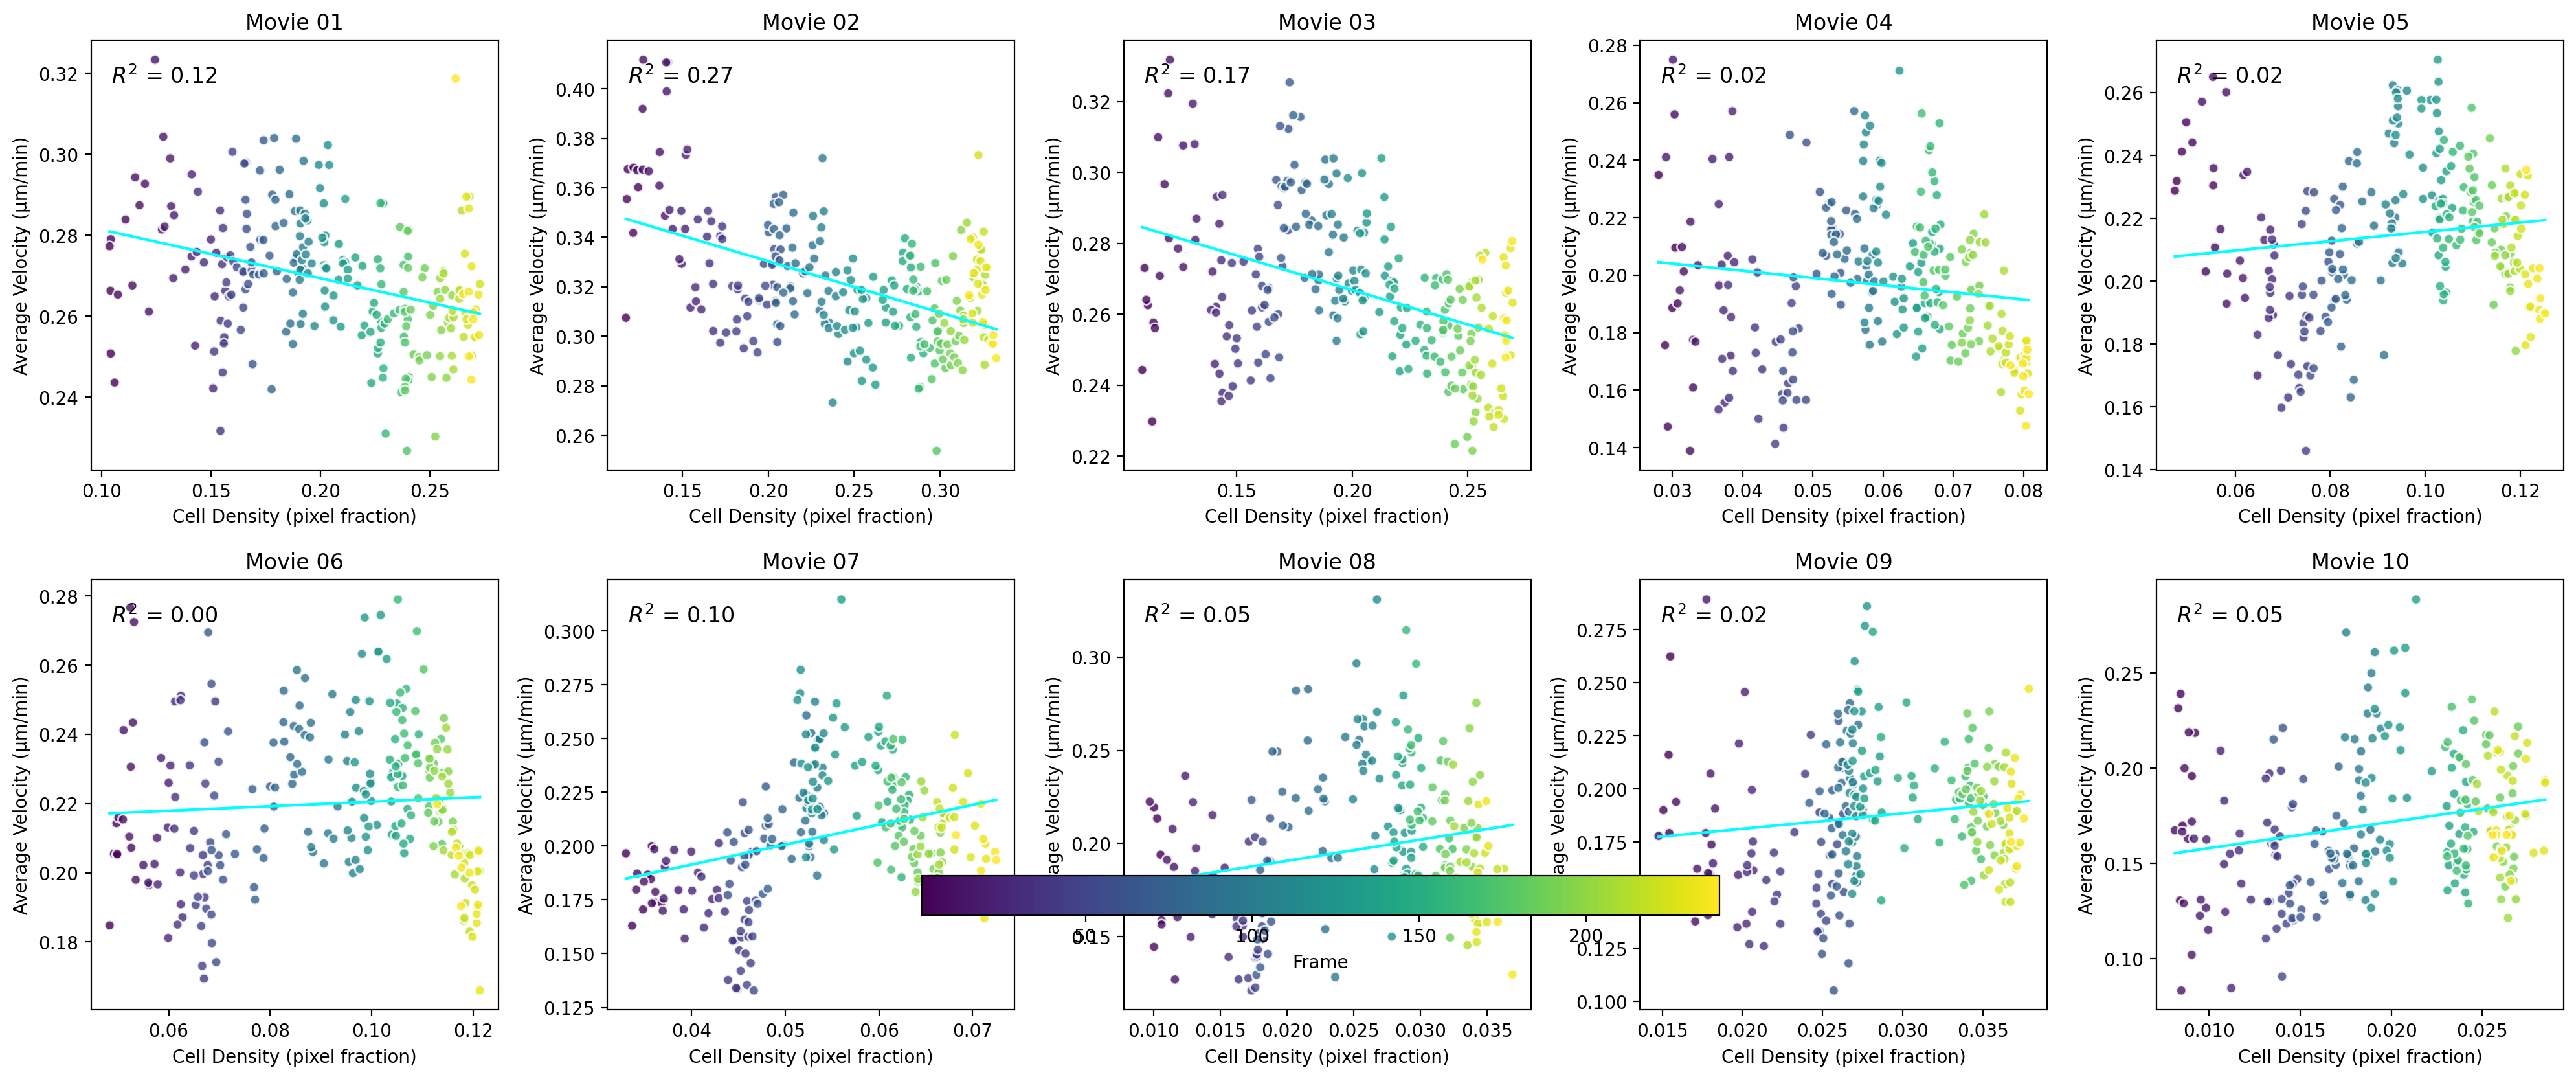

In [8]:
import matplotlib.colors as mcolors
movies = merged_df['movie'].unique()
n = len(movies)

# choose layout
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), dpi=200)
axes = axes.flatten()

# shared colormap normalized over all frames
vmin, vmax = merged_df['frame'].min(), merged_df['frame'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('viridis')

for ax, mv in zip(axes, movies):
    sub = merged_df[merged_df['movie'] == mv].dropna(subset=['frame', 'cell_density', 'average_velocity'])
    x = sub['cell_density'].values
    y = sub['average_velocity'].values
    f = sub['frame'].values

    # scatter colored by frame
    sc = ax.scatter(
        x, y,
        c=f,
        cmap=cmap,
        norm=norm,
        s=30,
        edgecolor='white',
        alpha=0.8
    )

    # linear fit if possible
    if len(x) > 1 and np.nanstd(x) > 0 and np.nanstd(y) > 0:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        r2 = r_value**2

        # plot regression line
        xs = np.linspace(x.min(), x.max(), 100)
        ys = intercept + slope*xs
        ax.plot(xs, ys, color='cyan', linewidth=1.5)

        # annotate R²
        ax.text(
            0.05, 0.90,
            f'$R^2$ = {r2:.2f}',
            transform=ax.transAxes,
            fontsize=12
        )
    else:
        ax.text(
            0.05, 0.90,
            'insufficient var.',
            transform=ax.transAxes,
            fontsize=12,
            color='gray'
        )

    ax.set_title(f"Movie {mv}")
    ax.set_xlabel('Cell Density (pixel fraction)')
    ax.set_ylabel('Average Velocity (μm/min)')

# remove unused axes
for ax in axes[n:]:
    fig.delaxes(ax)

# add a single horizontal colorbar below all subplots
cbar = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes,
    orientation='horizontal',
    fraction=0.05,
    pad=0.04
)
cbar.set_label('Frame')

plt.tight_layout()
plt.show()

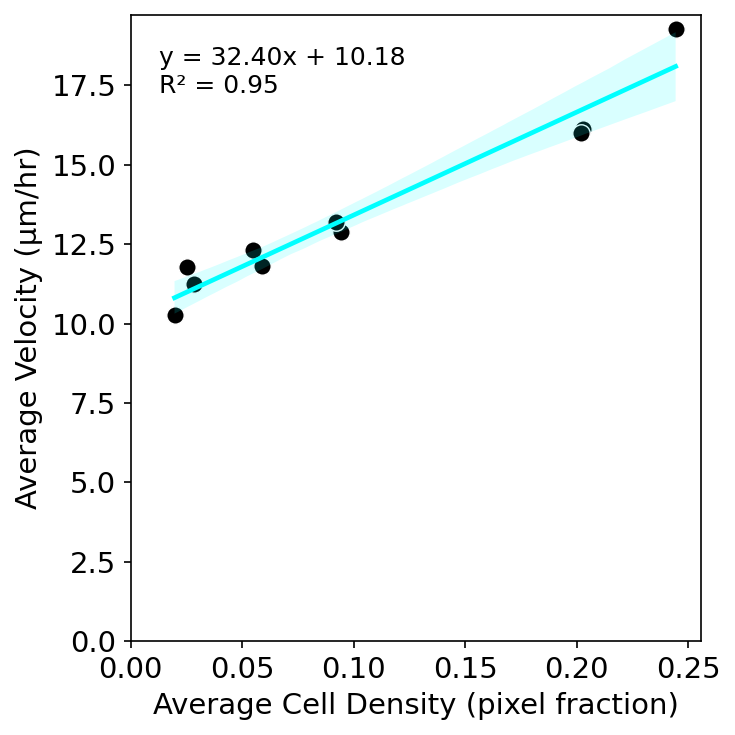

In [15]:
# compute per-movie averages (velocities in merged_df are μm/min)
movie_summary = merged_df.groupby('movie')[['cell_density', 'average_velocity']].mean().reset_index()

# convert velocity to μm/hour
movie_summary['average_velocity_um_per_hr'] = movie_summary['average_velocity'] * 60

# linear regression on converted values
slope, intercept, r_value, p_value, std_err = linregress(
    movie_summary['cell_density'], movie_summary['average_velocity_um_per_hr']
)
r_squared = r_value**2

# --- Create figure and axis ---
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

# plot
sns.scatterplot(data=movie_summary, x='cell_density', y='average_velocity_um_per_hr', 
                s=70, color='black', edgecolor='white', ax=ax)
sns.regplot(data=movie_summary, x='cell_density', y='average_velocity_um_per_hr', 
            scatter=False, color='cyan', ax=ax)

ax.grid(False)

# Annotations (velocity units are μm/hr)
textstr = '\n'.join([
    f'y = {slope:.2f}x + {intercept:.2f}',
    f'R² = {r_squared:.2f}'
])
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top')

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel("Average Cell Density (pixel fraction)", fontsize=14)
ax.set_ylabel("Average Velocity (μm/hr)", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()


## MSD and VACF per position

In [10]:
# calculate msd, autocorrelation and velocity for each movie separately
msd_dict = {}
dacf_dict = {}

# # grouping the data by movie
for movie, group in trajectory_df.groupby('movie'):
    msd_dict[movie] = calculate_msd(group)
    print(f"Calculated MSD for movie {movie}")
    dacf_dict[movie] = calculate_autocorrelation(group, directional=True)
    print(f"Calculated DACF for movie {movie}")

Calculated MSD for movie 01
Calculated DACF for movie 01
Calculated MSD for movie 02
Calculated DACF for movie 02
Calculated MSD for movie 03
Calculated DACF for movie 03
Calculated MSD for movie 04
Calculated DACF for movie 04
Calculated MSD for movie 05
Calculated DACF for movie 05
Calculated MSD for movie 06
Calculated DACF for movie 06
Calculated MSD for movie 07
Calculated DACF for movie 07
Calculated MSD for movie 08
Calculated DACF for movie 08
Calculated MSD for movie 09
Calculated DACF for movie 09
Calculated MSD for movie 10
Calculated DACF for movie 10


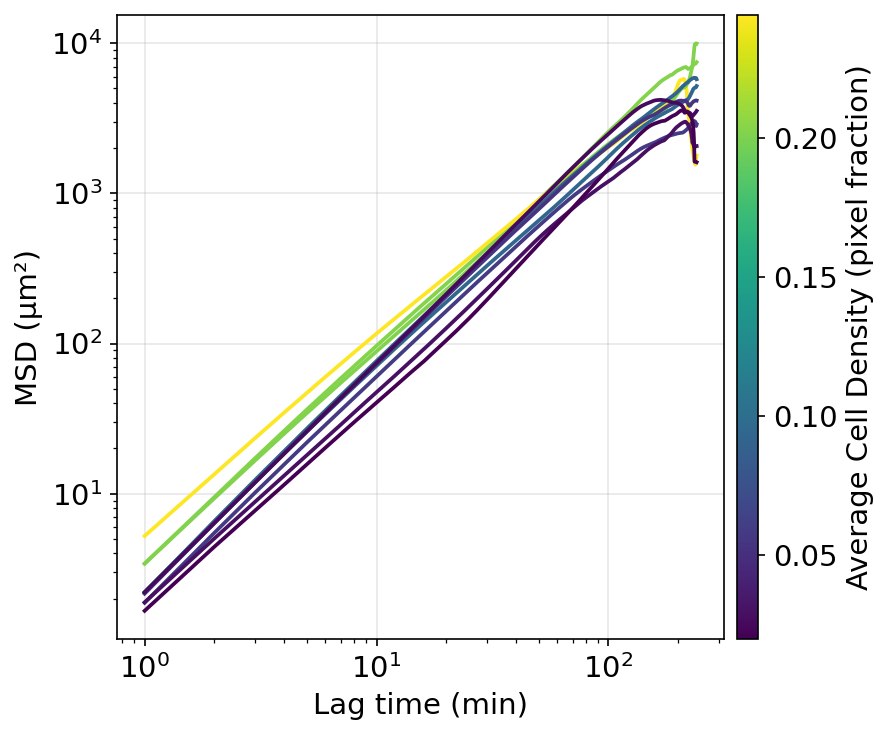

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import LogLocator, MaxNLocator

# --- Create figure and axis ---
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

ax.set_xlabel('Lag time (min)', fontsize=14)
ax.set_ylabel('MSD (μm²)', fontsize=14)

# --- Color by cell density ---
cmap = plt.cm.viridis
norm = mpl.colors.Normalize(
    vmin=movie_summary['cell_density'].min(),
    vmax=movie_summary['cell_density'].max()
)

# --- Plot MSD for each movie ---
for movie, msd_df in msd_dict.items():
    color = cmap(norm(movie_summary.loc[movie_summary['movie'] == movie, 'cell_density'].values[0]))
    ax.plot(
        msd_df['lag'], msd_df['msd'],
        label=f'Movie {movie}',
        color=color,
        linestyle='-',
        linewidth=1.8
    )

# --- Log-log axes ---
ax.set_xscale('log')
ax.set_yscale('log')

# Reduce number of ticks
ax.xaxis.set_major_locator(LogLocator(base=10, numticks=4))
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=4))

ax.grid(True, which='major', alpha=0.3)

# Tick fontsize
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# --- Add colorbar ---
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, pad=0.02, aspect=30, fraction=0.05)
cbar.set_label('Average Cell Density (pixel fraction)', fontsize=14)
cbar.locator = MaxNLocator(nbins=5)
cbar.update_ticks()
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()


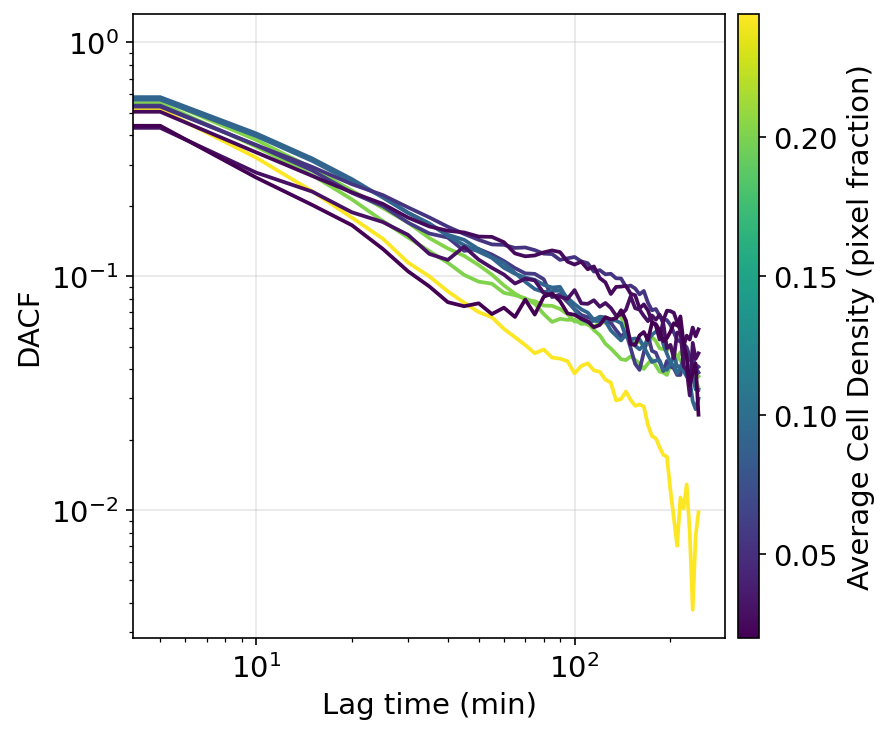

In [12]:
from matplotlib.ticker import MaxNLocator

# --- Create figure and axis explicitly ---
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

ax.set_xlabel('Lag time (min)', fontsize=14)
ax.set_ylabel('DACF', fontsize=14)

# color by cell density
cmap = plt.cm.viridis
norm = plt.Normalize(movie_summary['cell_density'].min(), movie_summary['cell_density'].max())

# plot each movie curve
for movie, dacf_df in dacf_dict.items():
    dacf_df = dacf_df.iloc[:50]  # limit lag to 30
    color = cmap(norm(movie_summary.loc[movie_summary['movie'] == movie, 'cell_density'].values[0]))
    ax.plot(
        dacf_df['dt'], dacf_df['dacf'],
        label=f'Movie {movie}',
        color=color,
        linestyle='-',
        linewidth=1.8
    )

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', alpha=0.3)
# ticks fontsize
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# --- Add colorbar correctly ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, pad=0.02, aspect=30, fraction=0.05)
cbar.set_label('Average Cell Density (pixel fraction)', fontsize=14)
cbar.locator = MaxNLocator(nbins=5)  # 5 or fewer ticks
cbar.update_ticks()
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()



Movie 01: Fitted parameters: a=3.146, b=0.829, c=1.660
Movie 02: Fitted parameters: a=4.153, b=1.012, c=2.885
Movie 03: Fitted parameters: a=2.940, b=0.845, c=1.420
Movie 04: Fitted parameters: a=-0.000, b=-0.000, c=-1.000
Movie 05: Fitted parameters: a=4.504, b=0.880, c=3.789
Movie 06: Fitted parameters: a=4.344, b=0.869, c=3.371
Movie 07: Fitted parameters: a=-0.000, b=-0.000, c=-1.000
Movie 08: Fitted parameters: a=-0.000, b=-0.000, c=-1.000
Movie 09: Fitted parameters: a=-0.000, b=-0.000, c=-1.000
Movie 10: Fitted parameters: a=0.336, b=0.404, c=-1.159


<Axes: xlabel='cell_density', ylabel='dacf_exponent'>

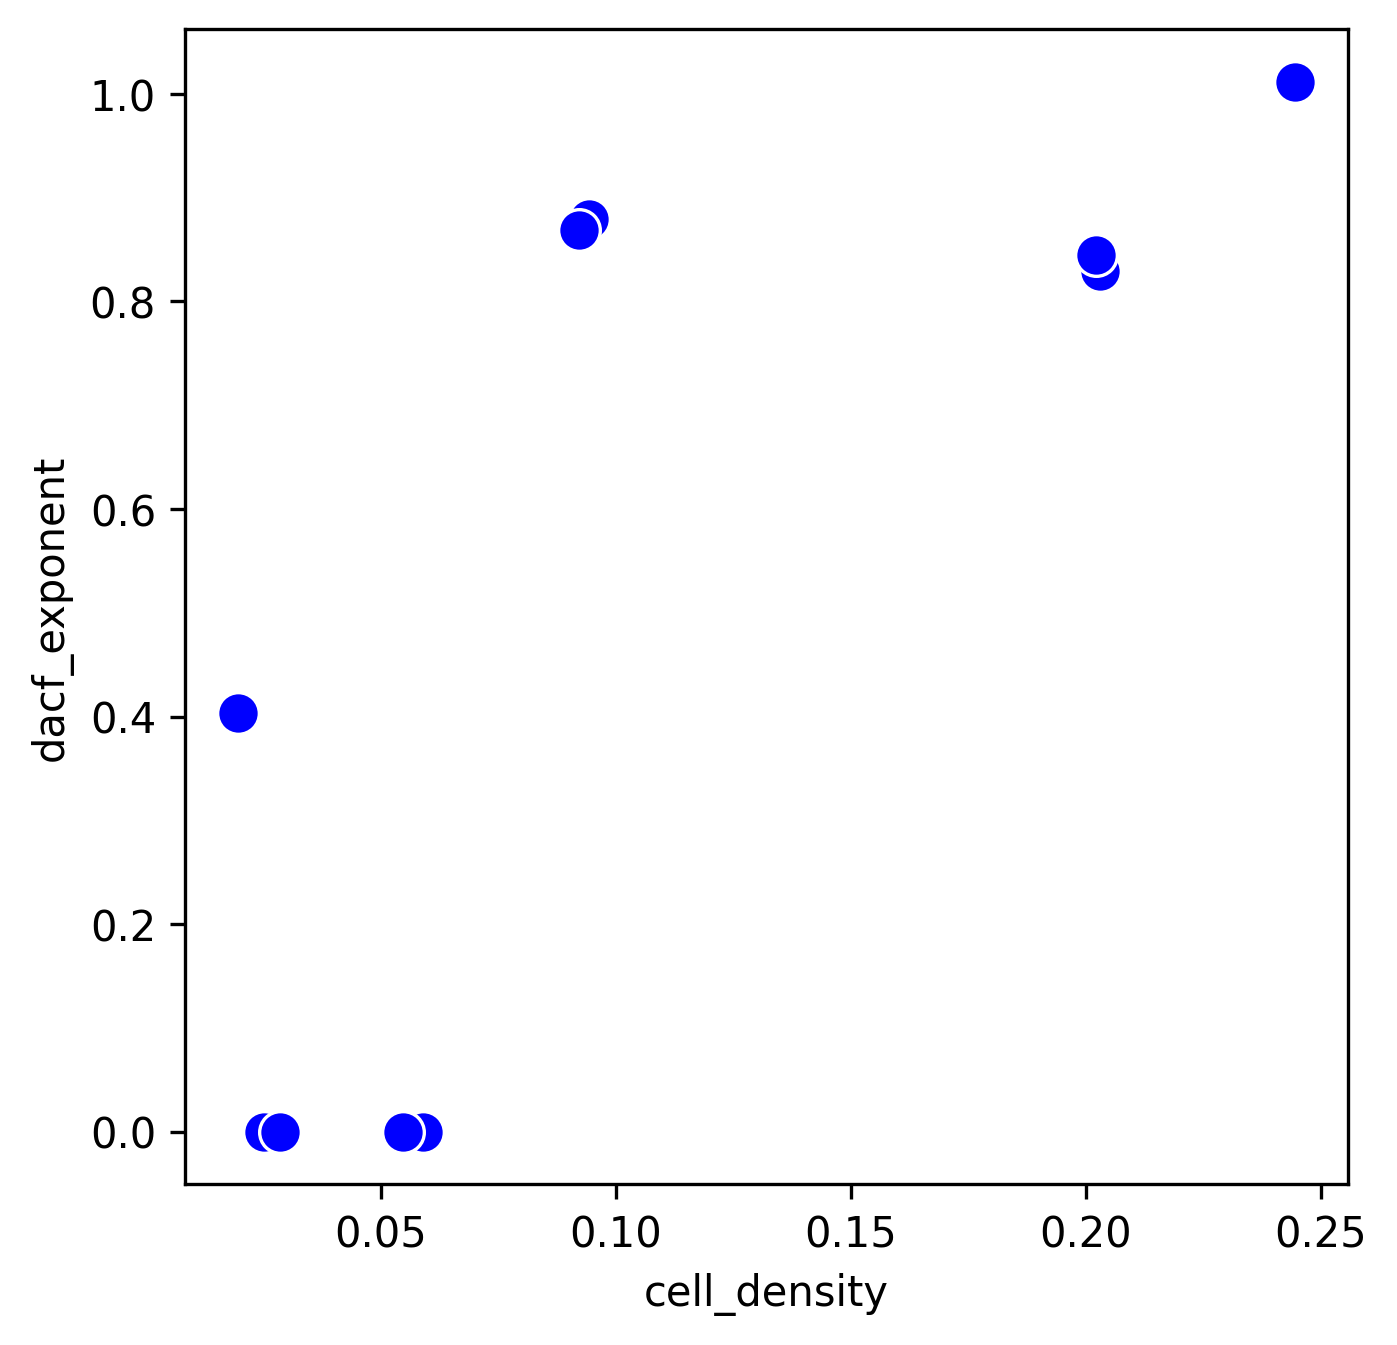

In [13]:
# fit power law to each dacf curve and extract alpha exponent, plot as function of cell density
def power_law(t, a, b,c):
    return a/(t**b+c)

for movie, dacf_df in dacf_dict.items():
    # select maximum lag where dacf to plot
    dacf_df = dacf_df.iloc[1:30+1]
    t = dacf_df['dt'].values
    y = dacf_df['dacf'].values

    # fit power law
    try:
        popt, pcov = curve_fit(power_law, t, y, p0=[1, 1, 1], maxfev=10000)
        a, b, c = popt
        print(f"Movie {movie}: Fitted parameters: a={a:.3f}, b={b:.3f}, c={c:.3f}")
    except RuntimeError as e:
        print(f"Movie {movie}: Curve fitting failed: {e}")
        continue

    # save exponent b to movie_summary
    movie_summary.loc[movie_summary['movie'] == movie, 'dacf_exponent'] = b

    # add cell count to movie_summary
    cell_count = trajectory_df[trajectory_df['movie'] == movie]['track_id'].nunique()
    movie_summary.loc[movie_summary['movie'] == movie, 'cell_count'] = cell_count

# plot dacf exponent vs cell density
plt.figure(figsize=(5, 5), dpi=300)
sns.scatterplot(data=movie_summary, x='cell_density', y='dacf_exponent', s=100, color='blue', edgecolor='white')


Text(0.05, 0.95, '$R^2$ = 0.26')

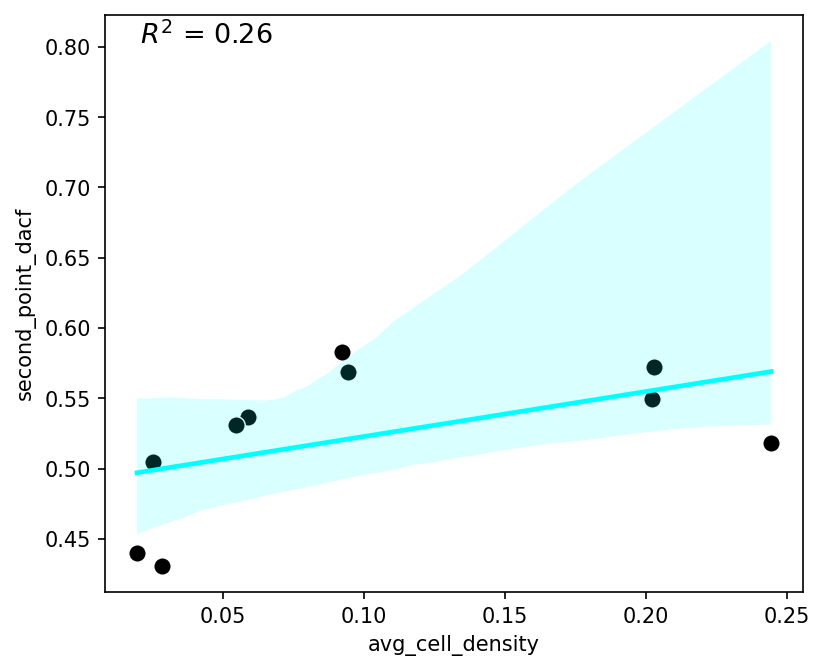

In [14]:
# second point of autocorrelation vs density
dacf_vs_density = []
for movie in movies:
    if movie in dacf_dict:
        dacf_df = dacf_dict[movie]
        if len(dacf_df) > 1:
            second_point_dacf = dacf_df.iloc[1]['dacf']
            avg_density = merged_df[merged_df['movie'] == movie]['cell_density'].mean()
            dacf_vs_density.append({
                'movie': movie,
                'second_point_dacf': second_point_dacf,
                'avg_cell_density': avg_density
            })

dacf_density_df = pd.DataFrame(dacf_vs_density)

# linear regression
slope, intercept, r_value, p_value, std_err = linregress(
    dacf_density_df['avg_cell_density'], dacf_density_df['second_point_dacf']
)

r_squared = r_value**2

# plot
plt.figure(figsize=(6, 5), dpi=150)
sns.scatterplot(data=dacf_density_df, x='avg_cell_density', y='second_point_dacf', s=70, color='black', edgecolor='white')
sns.regplot(data=dacf_density_df, x='avg_cell_density', y='second_point_dacf', scatter=False, color='cyan')

plt.text(0.05, 0.95, f'$R^2$ = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=13)
